# Agent Pick Rates on certain Maps

Original Pick Rate Values:
0    69%
1    56%
2    56%
3    44%
4    38%
5    31%
6    31%
7    25%
8    25%
9    25%
Name: Pick Rate, dtype: object
Cleaned Pick Rate Values:
count    24840.000000
mean        20.846940
std         32.861284
min          0.000000
25%          0.000000
50%          0.000000
75%         38.000000
max        100.000000
Name: Pick Rate, dtype: float64
Filtered Data contains 2640 rows.
Pivot Table:
Map            Abyss  All Maps  Ascent       Bind  Haven      Icebox  \
Agent                                                                  
astra      56.916667     10.80    0.00  13.428571    0.0    0.000000   
breach      0.000000     23.40    0.00   0.000000   66.7    0.000000   
brimstone   0.000000     12.40    0.00  74.857143    0.0    0.000000   
chamber     0.000000      4.04    0.00   7.642857    0.0    0.000000   
clove       0.000000      4.24    9.50   0.000000    0.0    0.000000   
cypher     77.083333     39.08   40.75  15.500000   77.8    0.00000

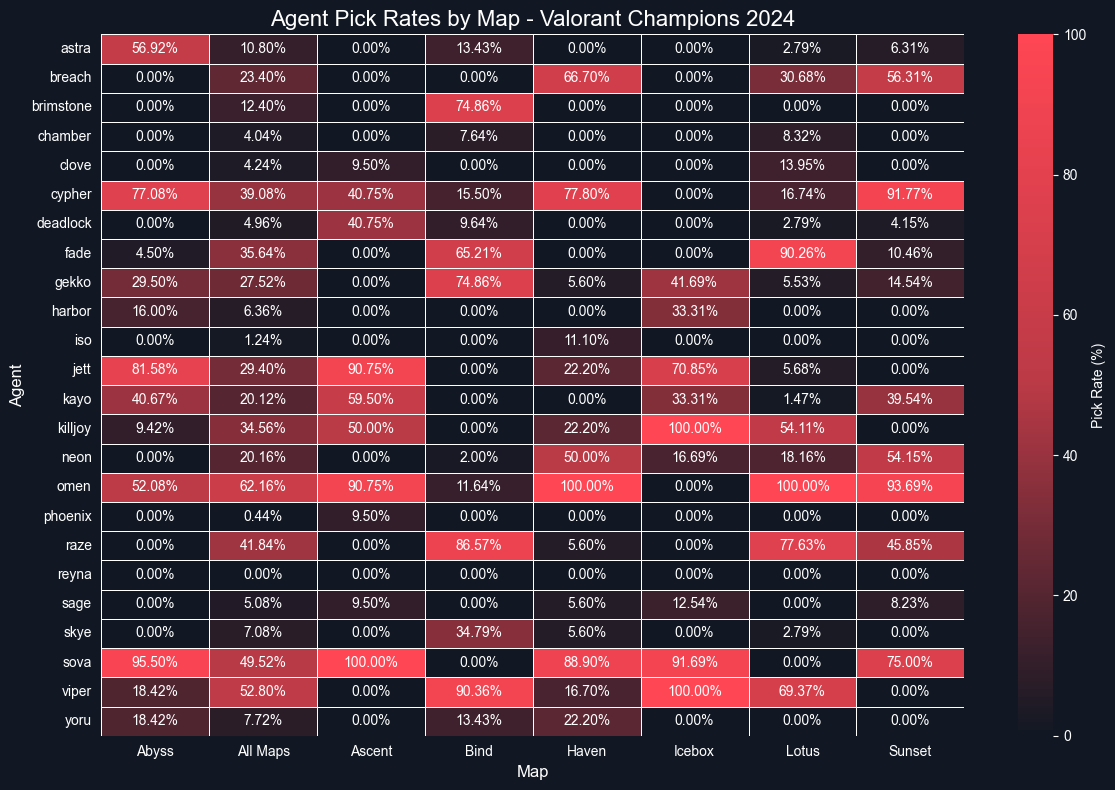

In [77]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist

# Load the CSV file
file_path = "valorant_data/vct_2024/agents/agents_pick_rates.csv"
data = pd.read_csv(file_path)

# Inspect the Pick Rate column
print("Original Pick Rate Values:")
print(data["Pick Rate"].head(10))

# Remove % sign and convert to numeric
data["Pick Rate"] = data["Pick Rate"].str.replace("%", "", regex=True).astype(float)

# Verify the conversion
print("Cleaned Pick Rate Values:")
print(data["Pick Rate"].describe())

# Filter the data for Valorant Champions 2024 (assuming there's a 'Tournament' column)
filtered_data = data[data["Tournament"] == "Valorant Champions 2024"]
print(f"Filtered Data contains {len(filtered_data)} rows.")

# Pivot the data to create a table of pick rates
heatmap_data = filtered_data.pivot_table(
    index="Agent", columns="Map", values="Pick Rate", aggfunc="mean"
)

# Fill NaN values with 0
heatmap_data = heatmap_data.fillna(0)
print("Pivot Table:")
print(heatmap_data)

# Perform hierarchical clustering on rows (agents) 
agent_distances = pdist(heatmap_data, metric='euclidean')
agent_linkage = linkage(agent_distances, method='ward')

# Cluster maps (columns) using the original order of columns
map_distances = pdist(heatmap_data.T, metric='euclidean')  # Transpose to cluster columns
map_linkage = linkage(map_distances, method='ward')

# Reorder the data based on the clustering
agent_dendrogram = dendrogram(agent_linkage, no_plot=True)
map_dendrogram = dendrogram(map_linkage, no_plot=True)

# Reordered indices based on the clustering
reordered_agents = agent_dendrogram['leaves']
reordered_maps = map_dendrogram['leaves']

# Reorder the heatmap data
ordered_heatmap_data = heatmap_data.iloc[reordered_agents, reordered_maps]

# Sort both agents and maps (columns) alphabetically
ordered_heatmap_data = ordered_heatmap_data[sorted(ordered_heatmap_data.columns)]
ordered_heatmap_data = ordered_heatmap_data.loc[sorted(ordered_heatmap_data.index)]

# Create the custom color palette
colors = ["#111823", "#ba3a46", "#ff4654"]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

# Set the style and background color using Matplotlib directly
plt.figure(figsize=(12, 8), facecolor="#111823")

# Plot the heatmap with the custom color palette and clustering
sns.heatmap(
    ordered_heatmap_data, annot=True, fmt=".2f", cmap=custom_cmap, linewidths=0.5,
    cbar_kws={"label": "Pick Rate (%)"},
    annot_kws={"size": 10}  # Adjust the annotation size if needed
)

# Add percentage sign in annotations
for text in plt.gca().texts:
    # Convert the number to percentage and format it
    new_value = f"{float(text.get_text()):.2f}%"
    text.set_text(new_value)

# Set the title and labels with white text for visibility on the dark background
plt.title("Agent Pick Rates by Map - Valorant Champions 2024", fontsize=16, color="white")
plt.xlabel("Map", fontsize=12, color="white")
plt.ylabel("Agent", fontsize=12, color="white")

# Adjust the labels' color to make them stand out
plt.gca().tick_params(axis="x", colors="white")
plt.gca().tick_params(axis="y", colors="white")

# Make colorbar label white
plt.gcf().axes[-1].yaxis.label.set_color('white')
plt.gcf().axes[-1].tick_params(axis='y', colors='white')

# Set grid color for better contrast if needed
plt.grid(False)  # Hide grid lines to maintain a clean look

# Show the plot
plt.tight_layout()
plt.show()


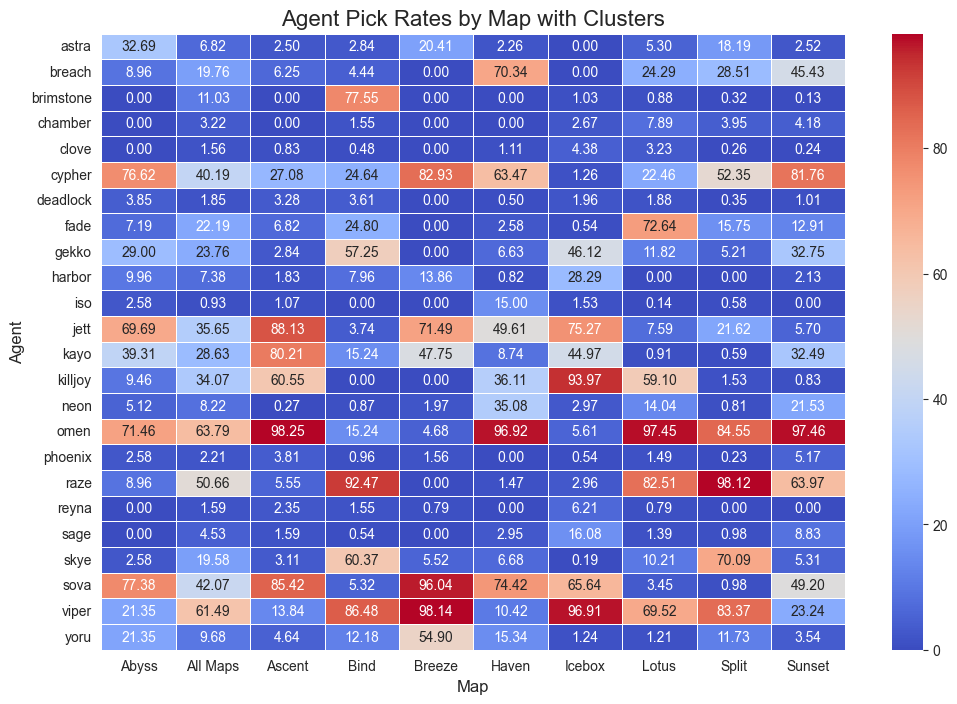

In [ ]:
from sklearn.cluster import KMeans
import numpy as np


X = heatmap_data.fillna(0).values

kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X)

heatmap_data['Cluster'] = cluster_labels

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data.iloc[:, :-1], annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Agent Pick Rates by Map with Clusters", fontsize=16)
plt.xlabel("Map", fontsize=12)
plt.ylabel("Agent", fontsize=12)
plt.show()


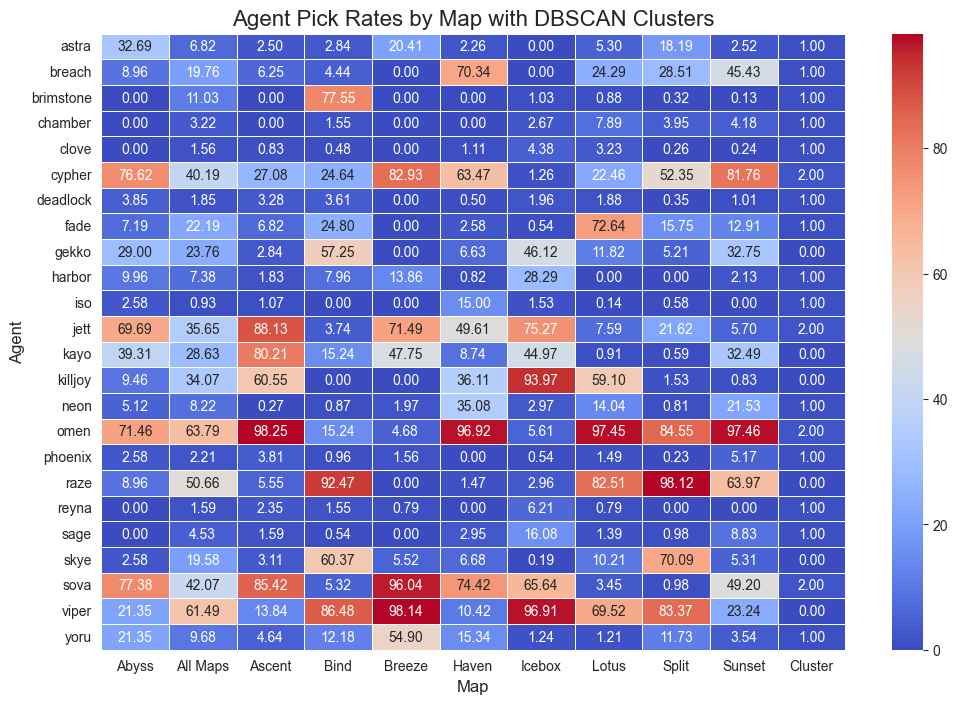

In [ ]:
from sklearn.cluster import DBSCAN

X = heatmap_data.fillna(0).values

dbscan = DBSCAN(eps=0.5, min_samples=3)
dbscan_labels = dbscan.fit_predict(X)

heatmap_data['DBSCAN Cluster'] = dbscan_labels

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data.iloc[:, :-1], annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Agent Pick Rates by Map with DBSCAN Clusters", fontsize=16)
plt.xlabel("Map", fontsize=12)
plt.ylabel("Agent", fontsize=12)
plt.show()


Index(['Agent', 'Abyss', 'All Maps', 'Ascent', 'Bind', 'Breeze', 'Haven',
       'Icebox', 'Lotus', 'Split', 'Sunset', 'Cluster', 'DBSCAN Cluster'],
      dtype='object', name='Map')


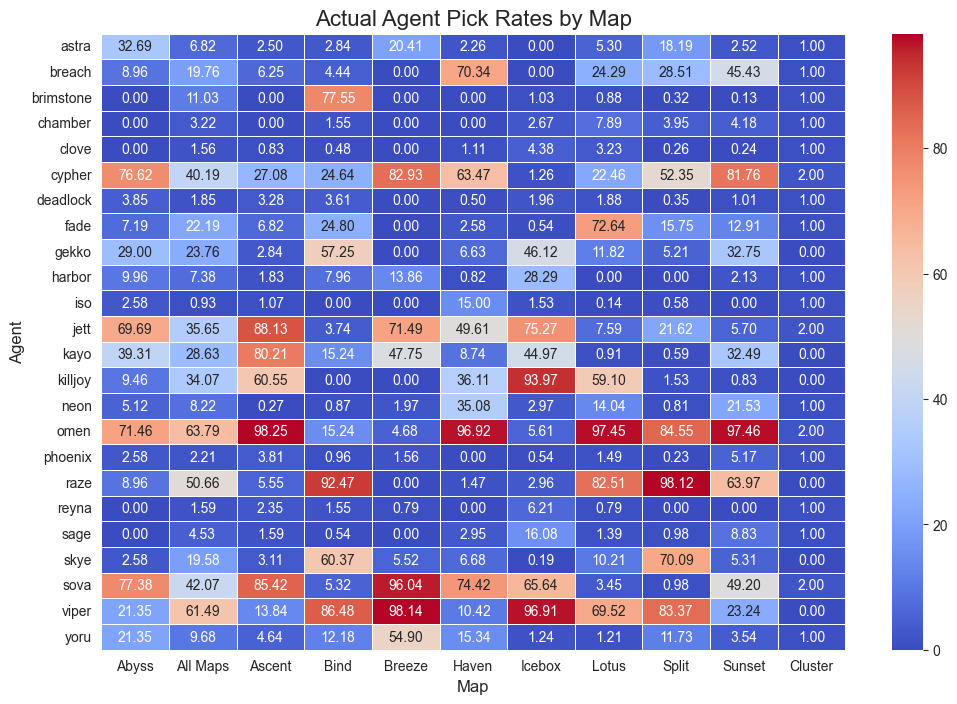

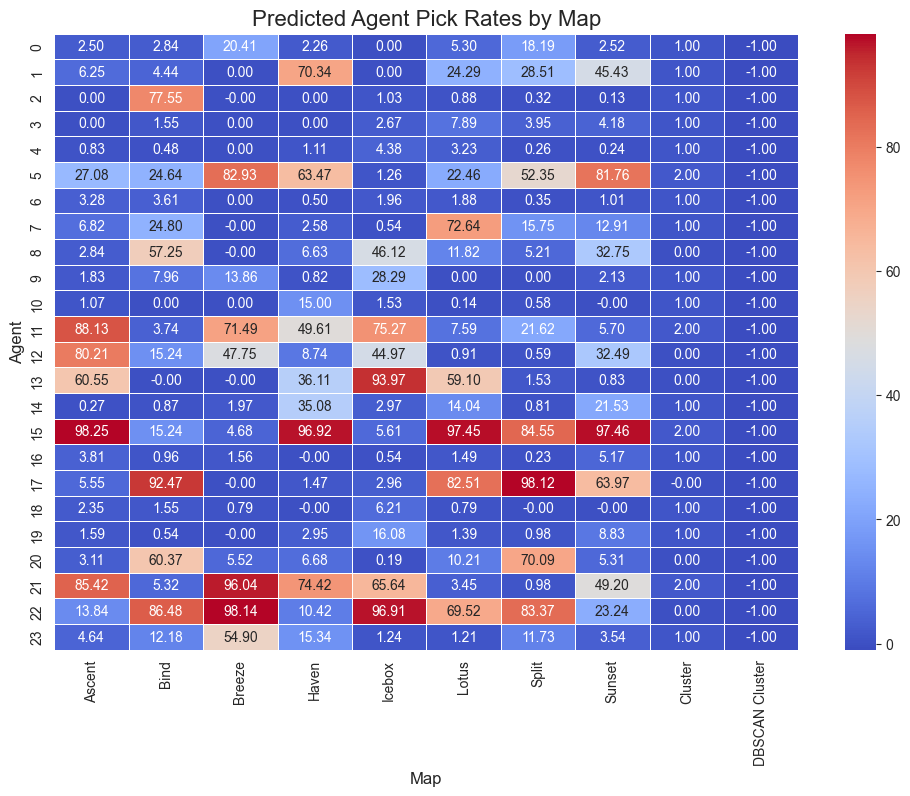

In [38]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming heatmap_data is your DataFrame with the format you showed
# Reset index to make sure 'Agent' is a regular column
heatmap_data_reset = heatmap_data.reset_index()

# Prepare the data for linear regression
# We'll treat 'Agent' as the predictor and the pick rates as the target variable
# We will create a separate model for each map

# Initialize the model
regressor = LinearRegression()

# Loop through each map and perform linear regression
predictions = {}
for map_name in heatmap_data.columns[2:]:  # Skip 'Agent' and 'Map' columns
    X = pd.DataFrame({'Agent': heatmap_data_reset['Agent']})
    X = pd.get_dummies(X, drop_first=True)  # Convert 'Agent' to dummy variables
    y = heatmap_data_reset[map_name]
    
    # Fit the model
    regressor.fit(X, y)
    
    # Make predictions
    predictions[map_name] = regressor.predict(X)

# Convert predictions to a DataFrame
predicted_df = pd.DataFrame(predictions)

# Inspect the columns of the reset dataframe to ensure correct column names
print(heatmap_data_reset.columns)

# If 'Map' is now an index and not a column, we should not try to drop it
# Visualize the actual pick rates using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_reset.set_index('Agent').drop(columns='DBSCAN Cluster'), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Actual Agent Pick Rates by Map", fontsize=16)
plt.xlabel("Map", fontsize=12)
plt.ylabel("Agent", fontsize=12)
plt.show()


# Visualize the predicted pick rates using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(predicted_df, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Predicted Agent Pick Rates by Map", fontsize=16)
plt.xlabel("Map", fontsize=12)
plt.ylabel("Agent", fontsize=12)
plt.show()


Filtered Data contains 1297 rows.


C:\Users\yanap\AppData\Local\Temp\ipykernel_15216\1438367165.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_stats['Clutches (won/played)'] = pd.to_numeric(team_stats['Clutches (won/played)'], errors='coerce')


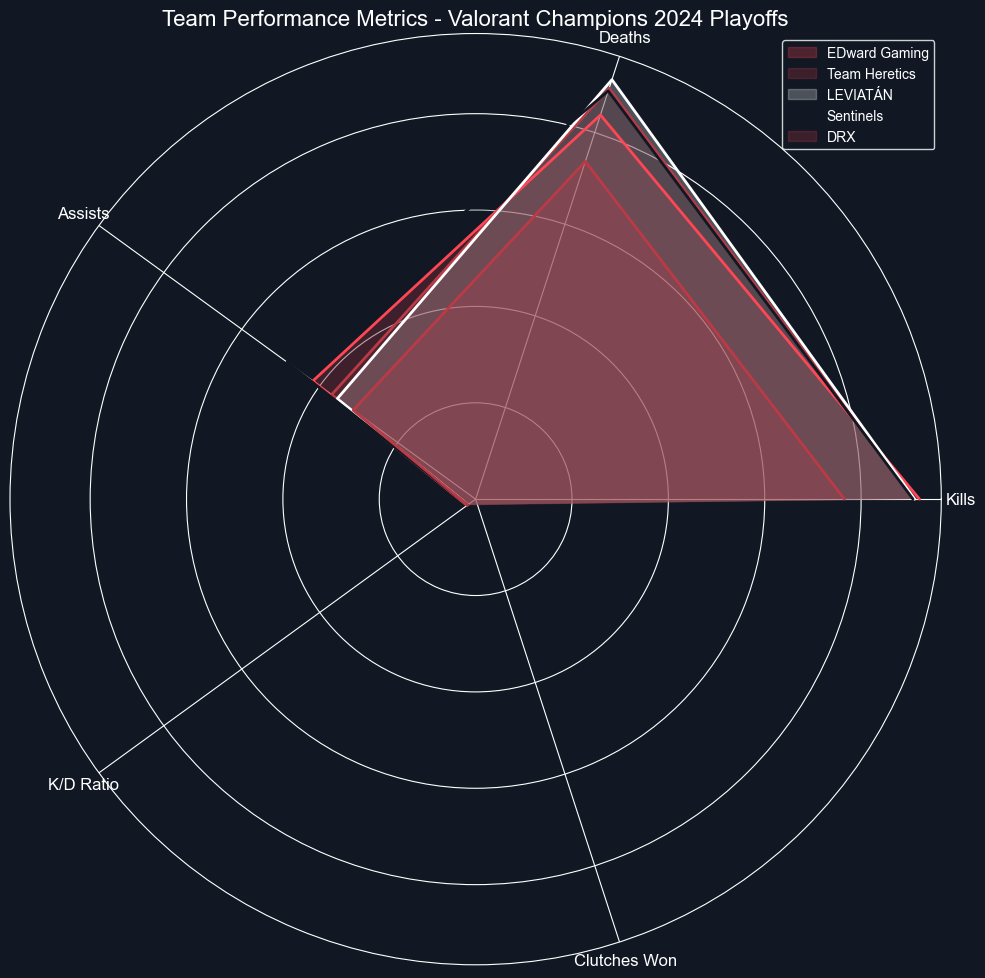

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = "valorant_data/vct_2024/players_stats/players_stats.csv"
data = pd.read_csv(file_path)

# Filter data for Valorant Champions 2024
filtered_data = data[data['Tournament'] == 'Valorant Champions 2024']
print(f"Filtered Data contains {len(filtered_data)} rows.")

# Define the top 5 teams
top_teams = ['EDward Gaming', 'Team Heretics', 'LEVIATÁN', 'Sentinels', 'DRX']

# Extract data for the top 5 teams (you can adjust the specific metrics here)
team_data = {}
for team in top_teams:
    team_stats = filtered_data[filtered_data['Teams'] == team]
    
    # Ensure 'Clutches (won/played)' is numeric, errors='coerce' converts non-numeric to NaN
    team_stats['Clutches (won/played)'] = pd.to_numeric(team_stats['Clutches (won/played)'], errors='coerce')
    
    # Calculate average stats for each metric (you can modify this to calculate other stats)
    avg_stats = {
        'Kills': team_stats['Kills'].mean(),
        'Deaths': team_stats['Deaths'].mean(),
        'Assists': team_stats['Assists'].mean(),
        'K/D Ratio': (team_stats['Kills'].sum() / team_stats['Deaths'].sum()) if team_stats['Deaths'].sum() > 0 else 0,
        'Clutches Won': team_stats['Clutches (won/played)'].mean()  # Now safely calculating the mean
    }
    team_data[team] = avg_stats

# Metrics for the radar chart
metrics = ['Kills', 'Deaths', 'Assists', 'K/D Ratio', 'Clutches Won']
num_vars = len(metrics)

# Compute the angle of each axis in the radar chart
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Dark mode color palette
colors = ['#ff4654', '#ba3a46', '#ffffff', '#111823', '#ba3a46']

# Create the radar chart
plt.figure(figsize=(10, 10), facecolor='#111823')
plt.style.use('dark_background')
ax = plt.subplot(111, polar=True)

# Plot data for each team
for i, (team, performance) in enumerate(team_data.items()):
    performance_values = [performance[metric] for metric in metrics]
    performance_values += performance_values[:1]  # Close the loop on the radar chart
    angles_with_repeat = angles + angles[:1]  # Add the first angle to close the circle
    ax.fill(angles_with_repeat, performance_values, alpha=0.25, color=colors[i], label=team)
    ax.plot(angles_with_repeat, performance_values, color=colors[i], linewidth=2)  # Plot each team's line

# Customize plot appearance
ax.set_facecolor('#111823')
ax.set_yticklabels([])  # Hide radial labels
ax.set_xticks(angles)
ax.set_xticklabels(metrics, fontsize=12, color='white')

# Add a title and legend
plt.title('Team Performance Metrics - Valorant Champions 2024 Playoffs', fontsize=16, color='white')
plt.legend(facecolor='#111823', edgecolor='white', labelcolor='white', loc='upper right')

# Display the chart
plt.tight_layout()
plt.show()

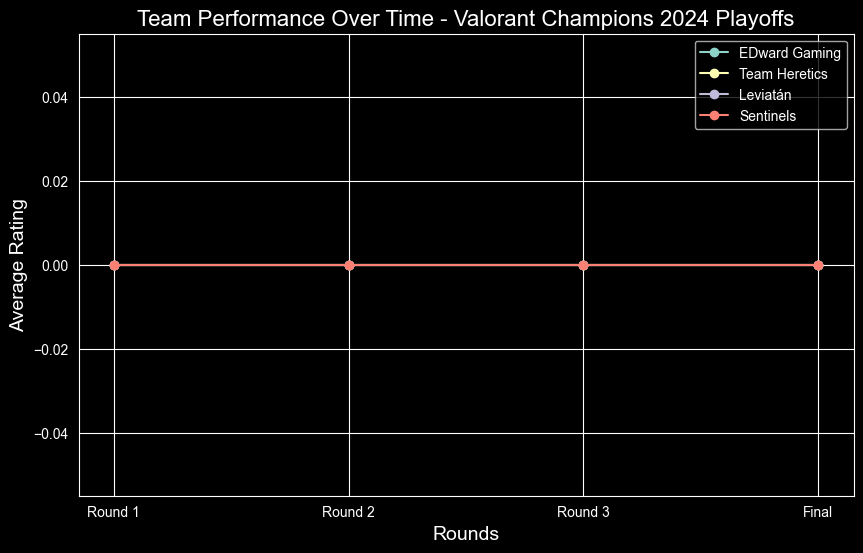

In [88]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
file_path = "valorant_data/vct_2024/players_stats/players_stats.csv"
data = pd.read_csv(file_path)

# Group by teams and calculate average ratings for each round
teams = ['EDward Gaming', 'Team Heretics', 'Leviatán', 'Sentinels']
rounds = ['Round 1', 'Round 2', 'Round 3', 'Final']

# Initialize a dictionary to store the average ratings for each team
team_data = {team: [] for team in teams}

# Iterate through each team and calculate the average rating per round
for team in teams:
    team_stats = data[data['Teams'] == team]
    
    # Assuming that "Rounds Played" indicates the round number and "Rating" represents performance
    for round_label in rounds:
        # Filter data by rounds and calculate the average rating for that round
        round_data = team_stats[team_stats['Rounds Played'] == round_label]
        if not round_data.empty:
            avg_rating = round_data['Rating'].mean()  # You can modify this to use other metrics like Kills, etc.
        else:
            avg_rating = 0  # If no data is available for that round, set it to 0 or another default value
        team_data[team].append(avg_rating)

# Plotting the line chart
plt.figure(figsize=(10, 6))

# Plot lines for each team
for team in teams:
    plt.plot(rounds, team_data[team], marker='o', label=team)

# Customize labels and title
plt.xlabel('Rounds', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)  # Modify to your chosen metric (e.g., "Average Kills" or "K/D Ratio")
plt.title('Team Performance Over Time - Valorant Champions 2024 Playoffs', fontsize=16)

# Add legend
plt.legend()

# Display the chart
plt.show()



Yearly Average Ratings:
   Year    Rating
0  2021  0.999196
1  2022  0.987612
2  2023  0.997943
3  2024  0.985019

Mean Squared Error (Yearly Regression): 2.561632617079936e-05
R² (Yearly Regression): 0.3359479077474341

Future Predictions:
   Year  Predicted Rating
0  2025          0.984393
1  2026          0.981173
2  2027          0.977953
3  2028          0.974733


c:\Users\yanap\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


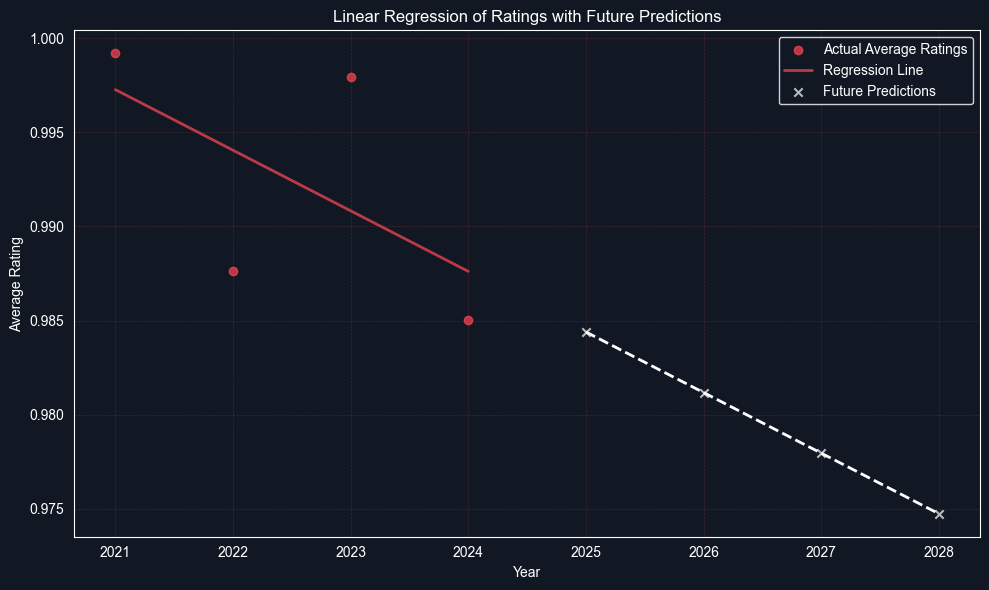

In [74]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

def convert_percentage_to_float(percentage_str):
    """
    Convert percentage string to float
    """
    if pd.isna(percentage_str):
        return None
    return float(percentage_str.strip('%')) / 100 if '%' in str(percentage_str) else float(percentage_str)

# Paths to the CSV files for different years
folder_paths = [
    r'valorant_data\vct_2024\players_stats\players_stats.csv',
    r'valorant_data\vct_2023\players_stats\players_stats.csv',
    r'valorant_data\vct_2022\players_stats\players_stats.csv',
    r'valorant_data\vct_2021\players_stats\players_stats.csv'
]

# Tournaments to filter
tournaments = [
    'Valorant Champions 2024',
    'Valorant Champions 2023',
    'Valorant Champions 2022',
    'Valorant Champions 2021'
]

# Initialize an empty list to store DataFrames
dataframes = []

# Read and filter CSV files for Valorant Champions tournaments
for path in folder_paths:
    try:
        # Read the CSV file
        df = pd.read_csv(path)
        
        # Filter for specific Valorant Champions tournaments
        df_filtered = df[df['Tournament'].isin(tournaments)].copy()
        
        # Add a Year column based on the file path
        if not df_filtered.empty:
            df_filtered.loc[:, 'Year'] = int(path.split('vct_')[-1].split('\\')[0])
            
            # Append to dataframes list
            dataframes.append(df_filtered)
    except Exception as e:
        print(f"Error processing {path}: {e}")

# Combine all filtered DataFrames into one
if dataframes:
    data = pd.concat(dataframes, ignore_index=True)
    
    # Clean and process data
    data['Clutch Success %'] = data['Clutch Success %'].apply(convert_percentage_to_float)
    data_clean = data.dropna(subset=['Rating'])
    
    # Group by year and calculate the average rating
    yearly_avg_rating = data_clean.groupby('Year')['Rating'].mean().reset_index()
    
    print("Yearly Average Ratings:")
    print(yearly_avg_rating)
    
    # Check if we have more than one year of data
    if len(yearly_avg_rating) > 1:
        # Prepare the feature matrix (X) and target vector (y)
        X_year = yearly_avg_rating[['Year']]
        y_rating = yearly_avg_rating['Rating']
        
        # Perform linear regression
        lin_reg_year = LinearRegression()
        lin_reg_year.fit(X_year, y_rating)
        
        # Predict ratings for the span of years
        y_pred_year = lin_reg_year.predict(X_year)
        
        # Evaluate the model
        mse_year = mean_squared_error(y_rating, y_pred_year)
        r2_year = r2_score(y_rating, y_pred_year)
        
        print(f"\nMean Squared Error (Yearly Regression): {mse_year}")
        print(f"R² (Yearly Regression): {r2_year}")
        
        # Prepare future years for prediction
        future_years = np.array([[2025], [2026], [2027], [2028]])
        future_predictions = lin_reg_year.predict(future_years)
        
        # Create a DataFrame for future predictions
        future_predictions_df = pd.DataFrame({
            'Year': future_years.flatten(),
            'Predicted Rating': future_predictions
        })
        
        print("\nFuture Predictions:")
        print(future_predictions_df)
        
        # Visualize the yearly average ratings with the regression line and future predictions
        plt.figure(figsize=(10, 6), facecolor='#111823')  # Dark background for the entire figure

        # Custom color palette based on the provided values
        historical_data_color = '#ff4654'  # (255, 70, 84) - Custom red
        regression_line_color = '#ba3a46'  # (186, 58, 70) - Custom pinkish red
        future_data_color = '#ffffff'      # (255, 255, 255) - White for future points
        background_color = '#111823'       # (17, 24, 35) - Dark background color

        # Create the plot with dark mode styling
        plt.style.use('dark_background')  # Use dark background style

        # Plot historical data
        plt.scatter(X_year, y_rating, color=historical_data_color, label='Actual Average Ratings', alpha=0.7)
        plt.plot(X_year, y_pred_year, color=regression_line_color, label='Regression Line', linewidth=2)

        # Plot future predictions
        plt.scatter(future_years, future_predictions, color=future_data_color, label='Future Predictions', alpha=0.7, marker='x')
        plt.plot(future_years, future_predictions, color=future_data_color, linestyle='--', linewidth=2)

        # Set plot area background to match the figure background
        plt.gca().set_facecolor('#111823')

        # Customize axes and labels for dark mode
        plt.xlabel('Year', color='white')
        plt.ylabel('Average Rating', color='white')
        plt.title('Linear Regression of Ratings with Future Predictions', color='white')

        # Customize tick colors
        plt.tick_params(axis='x', colors='white')
        plt.tick_params(axis='y', colors='white')

        # Customize legend
        plt.legend(facecolor='#111823', edgecolor='white', labelcolor='white')

        # Customize grid
        plt.grid(color='#ba3a46', linestyle='--', linewidth=0.5, alpha=0.3)

        # Tight layout and show
        plt.tight_layout()
        plt.show()  
    else:
        print("Not enough data points for regression analysis")
else:
    print("No data found for Valorant Champions tournaments")
